# Behavioral Patterns

The behavioral patterns are guidelines suggested to create classes that allows to communicate objects to each other. The goal of the behavioral patterns is to make those interactions easier and more understandable.

The five creational patterns available are:
1. Chain of Responsability
2. Command
3. Iterator
4. Mediator
5. Memento
6. Observer
7. State
8. Strategy
9. Template method
10. Visitor

Again, we are going to be convering eaach of the possible patterns and making some examples in the context of machine learning engineering.

# Template method

**What is a template?**

This is design pattern that defines the skeleton of an algorithm and allows that all child classes modify the inner functionalities, but keeping the same logic.

**When should we use it?**

This design pattern is suggested when a different pieces of code behave similarly and there are just small differences in the code.

**Scenario**

You're a machine learning engineer executing a forecasting project. You need to test different forecasting models quickly, so you've decided to create a unified wrapper for ARIMA, Theta, and Holt-Winters.

Let's create a random time-series for the modeling

In [260]:
from utilsforecast.data import generate_series
from utilsforecast.plotting import plot_series

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel

from abc import ABC

import pandas as pd

In [261]:
data = generate_series(n_series=1, freq="M", with_trend=True, seed=99)

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/utilsforecast/data.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


## Antipattern

The easiest antipattern to do is to create an isolated class for each possible model.

In [262]:
class ARIMAForecaster:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model = None

    def fit(self, df: pd.DataFrame, date_col: str, target_col: str) -> None:
        df = df.copy()
        df = df.sort_values(by=date_col)
        df = df.set_index(date_col)
        y = df[target_col]
        self.model = ARIMA(y, order=self.order).fit()

    def predict(self, steps):
        result = self.model.forecast(steps=steps).reset_index()
        result = result.rename(
            columns={"index": "ds", "predicted_mean": "ARIMAPredictions"}
        )
        return result

In [263]:
class ThetaForecaster:
    def __init__(self):
        self.model = None
        self.max_date_fitted = None
        self.freq = None

    def fit(self, df: pd.DataFrame, date_col: str, target_col: str) -> None:
        df = df.copy()
        self.max_date_fitted = df[date_col].max()
        self.freq = pd.infer_freq(df[date_col])
        df = df.sort_values(by=date_col)
        df = df.set_index(date_col)
        y = df[target_col]
        self.model = ThetaModel(y).fit()

    def predict(self, steps):
        prediction_range = pd.date_range(
            start=self.max_date_fitted, periods=steps + 1, freq="M"
        )[1:]
        result = self.model.forecast(steps=steps).reset_index()
        result = result.rename(
            columns={"index": "ds", "forecast": "ThetaModelPredictions"}
        )
        result["ds"] = prediction_range
        return result

In [264]:
class HoltWintersForecaster:
    def __init__(self):
        self.model = None

    def fit(self, df: pd.DataFrame, date_col: str, target_col: str) -> None:
        df = df.copy()
        df = df.sort_values(by=date_col)
        df = df.set_index(date_col)
        y = df[target_col]
        self.model = ExponentialSmoothing(y).fit()

    def predict(self, steps):
        result = self.model.forecast(steps=steps).reset_index()
        result = result.rename(columns={"index": "ds", 0: "HoltWintersPredictions"})
        return result

Let's implement those models

In [265]:
arima_model = ARIMAForecaster(order=(2, 1, 2))
theta_model = ThetaForecaster()
holt_winters_model = HoltWintersForecaster()

Fit those models

In [266]:
arima_model.fit(data, date_col="ds", target_col="y")

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [267]:
theta_model.fit(data, date_col="ds", target_col="y")

In [268]:
holt_winters_model.fit(data, date_col="ds", target_col="y")

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Make inference over those models

In [269]:
forecast_arima = arima_model.predict(steps=12)
forecast_theta = theta_model.predict(steps=12)
forecast_holt_winters = holt_winters_model.predict(steps=12)

/var/folders/t1/1g6kqykj7pjbt9l4nwcplwz00000gn/T/ipykernel_53312/3030388921.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prediction_range = pd.date_range(
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/forecasting/theta.py:44: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  return DeterministicTerm._extend_index(index, steps)


See those predictions in a single plot

In [270]:
forecast_theta.dtypes

ds                       datetime64[ns]
ThetaModelPredictions           float64
dtype: object

In [271]:
forecast_arima.dtypes

ds                  datetime64[ns]
ARIMAPredictions           float64
dtype: object

In [272]:
forecast_holt_winters.dtypes

ds                        datetime64[ns]
HoltWintersPredictions           float64
dtype: object

In [273]:
all_forecasts = pd.merge(forecast_arima, forecast_theta, on="ds")
all_forecasts = pd.merge(all_forecasts, forecast_holt_winters, on="ds")

In [274]:
all_forecasts["unique_id"] = 0

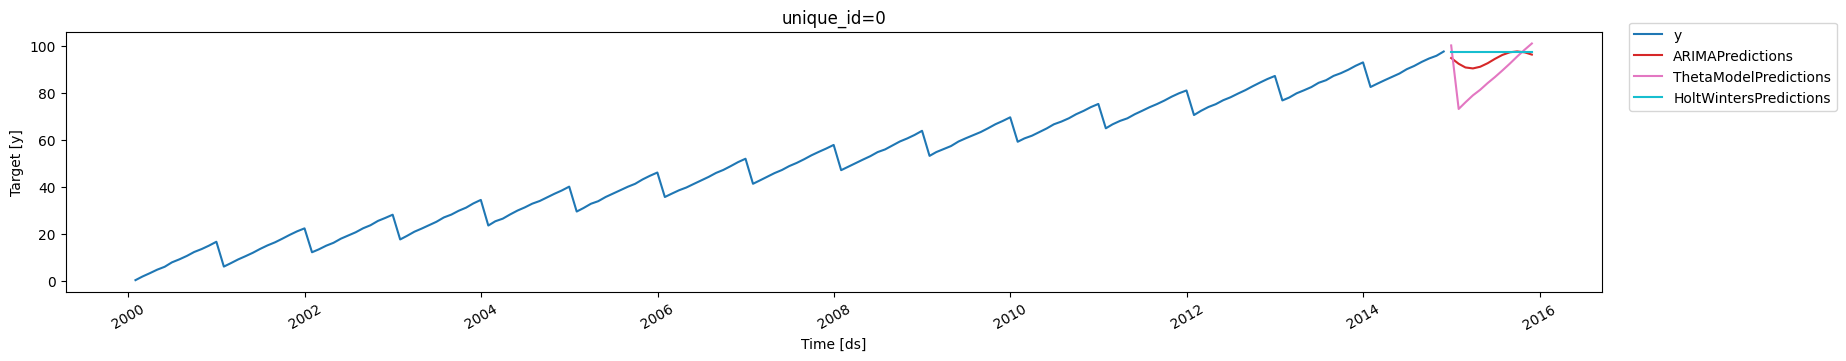

In [275]:
plot_series(data, all_forecasts)

As you see before, we have splitted the classes into different classes and that is a good way to do. However, we are falling into the DRY issue. There is a lot code lines that are repeated. Thus, we need a design pattern that allows to include new functionalities if needed, but keeping most of the code reusable.

**How to solve this antipattern?**

1. Creater a mother class that encapsulates most of the patterns needed. 
2. Create child classes and implement if needed additional logic.

## Pattern

1. Let's beging with the mother forecasting class

In [276]:
class ForecastingModel(ABC):
    def __init__(self, *model_args, **model_kwargs):
        self.model_instance = None
        self.fitted_model = None
        self.model_args = model_args
        self.model_kwargs = model_kwargs

    def fit(self, df: pd.DataFrame, date_col: str, target_col: str) -> None:
        df = df.copy()
        df = df.sort_values(by=date_col)
        df = df.set_index(date_col)
        y = df[target_col]
        self.fitted_model = self.model_instance(
            y, *self.model_args, **self.model_kwargs
        ).fit()

    def predict(self, steps):
        return self.fitted_model.forecast(steps=steps).reset_index()

2. Implement the ARIMA class

In [277]:
class NewARIMAForecaster(ForecastingModel):
    def __init__(self, order=(1, 1, 1), *args, **kwargs):
        self.model_kwargs = {"order": order}
        if kwargs:
            self.model_kwargs.update(kwargs)
        self.model_args = args
        super().__init__(*self.model_args, **self.model_kwargs)
        self.model_instance = ARIMA

    def predict(self, steps):
        result = super().predict(steps)
        result = result.rename(
            columns={"index": "ds", "predicted_mean": "ARIMAPredictions"}
        )
        return result

3. Implement the Holt-Winter class

In [278]:
class NewHoltWintersForecaster(ForecastingModel):
    def __init__(self, *args, **kwargs):
        self.model_args = args
        self.model_kwargs = kwargs
        super().__init__(*self.model_args, **self.model_kwargs)
        self.model_instance = ExponentialSmoothing

    def predict(self, steps):
        result = super().predict(steps=steps)
        result = result.rename(columns={"index": "ds", 0: "HoltWintersPredictions"})
        return result

4. Implement the Theta class

In [279]:
class NewThetaForecaster(ForecastingModel):
    def __init__(self, *args, **kwargs):
        self.model_args = args
        self.model_kwargs = kwargs
        super().__init__(*self.model_args, **self.model_kwargs)
        self.model_instance = ThetaModel
        self.max_date_fitted = None
        self.infer_freq = None

    def fit(self, df, date_col, target_col):
        self.max_date_fitted = df[date_col].max()
        self.infer_freq = pd.infer_freq(df[date_col])
        return super().fit(df, date_col, target_col)

    def predict(self, steps):
        result = super().predict(steps=steps)
        result = result.rename(columns={"index": "ds", "forecast": "ThetaPredictions"})
        prediction_range = pd.date_range(
            start=self.max_date_fitted,
            periods=steps + 1,
            freq=self.infer_freq,
            inclusive="neither",
        )
        result["ds"] = prediction_range
        return result

Let's try the previous models

In [280]:
new_arima_model = NewARIMAForecaster(order=(2, 1, 2))
new_theta_model = NewThetaForecaster()
new_holt_winters_model = NewHoltWintersForecaster()

Fit the new models

In [281]:
new_arima_model.fit(data, date_col="ds", target_col="y")
new_theta_model.fit(data, date_col="ds", target_col="y")
new_holt_winters_model.fit(data, date_col="ds", target_col="y")

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dev/lib/python3.11/site-

Get predictions from the new models

In [282]:
y_pred_arima = new_arima_model.predict(steps=12)
y_pred_theta = new_theta_model.predict(steps=12)
y_pred_holt_winters = new_holt_winters_model.predict(steps=12)

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/forecasting/theta.py:44: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  return DeterministicTerm._extend_index(index, steps)


Concat all previous predictions

In [283]:
new_all_forecasts = pd.merge(y_pred_arima, y_pred_theta, on="ds")
new_all_forecasts = pd.merge(new_all_forecasts, y_pred_holt_winters, on="ds")

In [286]:
new_all_forecasts["unique_id"] = 0

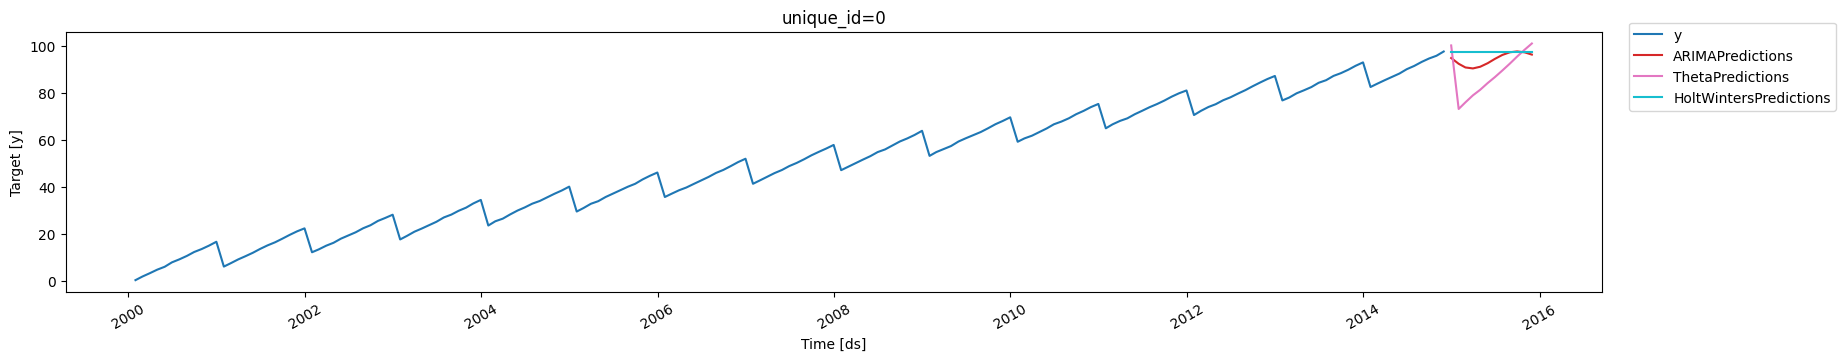

In [287]:
plot_series(data, new_all_forecasts)

As you see before, the template pattern allowed to avoid as much as possible the DRY issue. In addition, it kept the code as small as possible.